# Mass conserving temperature

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

root_path = os.path.join(Path().resolve().parent.parent.parent)

if str(root_path) not in sys.path:
    sys.path.insert(0, str(root_path))

import hamageolib.utils.plot_helper as plot_helper
from hamageolib.utils.exception_handler import my_assert

base_dir = Path().resolve()

results_dir = os.path.join(root_path, "dtemp")
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# Create 2d cases

In [2]:
create_2d_cases = True
run_create_2d_cases_first_step = True

if create_2d_cases:

    # options 
    case_name = "test_box"
    case_root_dir = "/mnt/lochy/ASPECT_DATA/TwoDMassConverving/2d_tests"

    # path to a aspect executable, only needed if run_create_2d_cases_first_step = True
    aspect_dir = "/home/lochy/Softwares/aspect"
    aspect_executable = os.path.join(aspect_dir, "build_master_TwoD_rebase/aspect")
    
    case_options = {
      "base directory": os.path.join(root_path, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/240106"), 
      "branch": "master_TwoD_rebase",
      "output directory": case_root_dir,
      "name": case_name,
      "depth average file": os.path.join(root_path, "hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_ThD/depth_average_1573.txt"),
      "include fast first step": 1,
      "version": 3.0,
      "test initial steps": {
        "number of outputs": 3,
        "interval of outputs": 10000.0
      },
      "geometry": "box",
      "potential temperature": 1573.0,
      "boundary condition": {
        "model": "all free slip"
      },
      "use world builder": 1,
      "world builder": {
        "use new ridge implementation": 1,
        "plate age method": "adjust box width only assigning age",
        "box width before adjusting": 8896000.0,
        "adjust mesh with box width": 1,
        "subducting plate": {
          "age trench": 80000000.0,
          "sp rate": 0.05,
          "trailing length": 600000.0
        },
        "overiding plate": {
          "age": 40000000.0,
          "transit": {
            "age": 20000000.0,
            "length": 700000.0
          },
          "trailing length": 600000.0
        },
        "maximum repetition slice": 1000000.0,
        "fix boudnary temperature auto": 1,
        "box height": 1000000.0
      },
      "coupling the eclogite phase to shear zone viscosity": 0,
      "slurm": [
        {
          "slurm file": os.path.join(root_path, "tests/fixtures/research/haoyuan_2d_subduction/slurm_files/230924/job_p-billen.sh"),
          "build directory": "master_TwoD",
          "tasks per node": 8,
          "cpus": 8
        }
      ],
      "use new rheology module": 1,
      "mantle rheology": {
        "scheme": "HK03_WarrenHansen23",
        "flow law": "composite",
        "adjust detail": 1,
        "jump lower mantle": 60.0,
        "Coh": 300.0,
        "use 3d da file": 1
      },
      "include peierls creep": 1,
      "peierls creep": {
        "scheme": "MK10",
        "maximum peierls iterations": 100,
        "fix peierls V as": "dislocation"
      },
      "refinement level": 10,
      "minimum viscosity": 1e+19,
      "refinement scheme": "3d consistent",
      "reset density": 1,
      "refinement": {
        "global refinement": 3,
        "adaptive refinement": 4
      },
      "phase transition model CDPT type": "HeFESTo_consistent",
      "shear zone": {
        "thickness": 15000.0,
        "slab core viscosity": 1e+22
      },
      "prescribe temperature method": "plate model 1",
      "prescribe temperature width": 900000.0,
      "prescribe temperature with trailing edge": 1,
      "slab": {
        "strength": 300000000.0
      },
      "composition method": {
        "scheme": "field"
      },
    }


In [3]:
if create_2d_cases:

    from hamageolib.research.haoyuan_2d_subduction.legacy_tools import create_case_with_json, CASE_TWOD, CASE_OPT_TWOD
    create_case_with_json(case_options, CASE_TWOD, CASE_OPT_TWOD)

create_case_with_json: Creating case
    Read inputs from /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/240106/case.prm
    Read world builder options from /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/legacy_files/reference_TwoD/240106/case.wb
Dsz:  15000.0
slope_660:  -1000000.0
refit rheology
strain_rate_diff_ref:  4.0518284522620205e-06
strain_rate_disl_ref:  5.255514965772285e-07
New json: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/../../../dtemp/rheology_results/mantle_profile_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1.0000e+00.json
New json: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/../../../dtemp/rheology_results/mantle_profile_aspect_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1

## Optional: run the first step and plot the outputs

It takes 30 s to run the case with 3 + 4 refinement level

In [4]:
if create_2d_cases and run_create_2d_cases_first_step:
    import subprocess, re

    case_dir = os.path.join(case_root_dir, case_name)
    prm_path = os.path.join(case_dir, "case_f.prm")

    # Run the ASPECT executable with the parameter file
    # The function ensures that both the expected outputs are generated and no errors are produced
    # 'capture_output=True' collects both stdout and stderr for further checks
    # 'cwd' set the run from case_dir
    completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True, cwd=case_dir)

    # Capture the standard output and error streams
    stdout = completed_process.stdout
    stderr = completed_process.stderr

    # Uncomment the following lines for debugging purposes to inspect the output
    # print(stdout)  # Debugging: Prints the standard output
    # print(stderr)  # Debugging: Prints the standard error

    # Check if the expected line indicating wallclock time appears in the output
    # The expected line format is something like:
    # -- Total wallclock time elapsed including restarts: 1s
    assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

    # Ensure that the error stream is empty, indicating no issues during the run
    assert(stderr == "")

### Run post-processing

First, read in the pvtu outputs at the 0th step (i.e. snapshot = adaptive refinement)

In [5]:
if create_2d_cases and run_create_2d_cases_first_step:

    import vtk
    from vtk.util.numpy_support import vtk_to_numpy
    from hamageolib.utils.vtk_utilities import calculate_resolution
    from hamageolib.research.haoyuan_2d_subduction.legacy_tools import VISIT_OPTIONS_TWOD as CASE_OPTIONS
    import time
    from scipy.interpolate import LinearNDInterpolator

    pvtu_file = os.path.join(case_dir, "output", "solution", "solution-%05d.pvtu" % int(case_options["refinement"]["adaptive refinement"]))
    assert(os.path.isfile(pvtu_file))

    # read case options
    Case_Options = CASE_OPTIONS(case_dir)
    Case_Options.Interpret()
    Case_Options.SummaryCaseVtuStep(os.path.join(case_dir, "summary.csv"))

    box_length = float(Case_Options.options["BOX_LENGTH"])

    # prepare output locations
    img_dir = os.path.join(case_dir, "img")
    if not os.path.isdir(img_dir):
        os.mkdir(img_dir)

    # Read the pvtu file
    start = time.time()

    reader = vtk.vtkXMLPUnstructuredGridReader()
    reader.SetFileName(pvtu_file)
    reader.Update()

    end = time.time()
    print("Initiating reader takes %.2e s" % (end - start))
    start = end

    # Get the output data from the reader
    grid = reader.GetOutput()  # Access the unstructured grid
    data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
    points = grid.GetPoints()  # Extract the points (coordinates)
    cells = grid.GetCells()  # Extract the cell connectivity information
    point_data = data_set.GetPointData()  # Access point-wise data

    n_points = grid.GetNumberOfPoints() # Number of points and cells
    n_cells = grid.GetNumberOfCells()

    end = time.time()
    print("Reading files takes %.2e s" % (end - start))
    print(f"\tNumber of points: {n_points}")
    print(f"\tNumber of cells: {n_cells}")
    print("\tAvailable point data fields:")
    for i in range(point_data.GetNumberOfArrays()):
        # Field names in point data
        name = point_data.GetArrayName(i)
        print(f"\t  - {name}")
    start = end

    # Convert data to numpy array
    # Get coordinates (points)
    # Get field "T"
    vtk_points = grid.GetPoints().GetData()
    points_np = vtk_to_numpy(vtk_points)  # Shape: (n_points, 3)
    points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

    vtk_T = point_data.GetArray("T")
    vtk_p = point_data.GetArray("p")
    assert(vtk_T is not None)
    T_np = vtk_to_numpy(vtk_T)  # Shape: (n_points,)
    assert(vtk_p is not None)
    p_np = vtk_to_numpy(vtk_p)  # Shape: (n_points,)

    end = time.time()
    print("Converting data takes %.2e s" % (end - start))
    start = end

    # Calculate resolution for each cell or point in the grid
    resolution_np = calculate_resolution(grid)  # Custom function (not defined here)

    end = time.time()
    print("Calculating resolution takes %.2e s" % (end - start))
    start = end


    # Create interpolators for temperature, pressure, and resolution
    interpolator = LinearNDInterpolator(points_2d, T_np)  # Interpolator for temperature
    interpolator_P = LinearNDInterpolator(points_2d, p_np)  # Interpolator for pressure
    interpolator_r = LinearNDInterpolator(points_2d, resolution_np)  # Interpolator for resolution

    end = time.time()
    print("Construct linear ND interpolator takes %.2e s" % (end - start))

/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/utils/file_reader.py:134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(
/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/utils/file_reader.py:134: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(


self.options['GRAPHICAL_STEPS']:  [0]
Initiating reader takes 3.09e-02 s
Reading files takes 7.20e-05 s
	Number of points: 120258
	Number of cells: 53448
	Available point data fields:
	  - velocity
	  - stress
	  - p
	  - T
	  - spcrust
	  - spharz
	  - opcrust
	  - opharz
	  - density
	  - thermal_expansivity
	  - specific_heat
	  - viscosity
	  - current_cohesions
	  - current_friction_angles
	  - plastic_yielding
	  - dislocation_viscosity
	  - diffusion_viscosity
	  - peierls_viscosity
	  - nonadiabatic_pressure
	  - strain_rate
	  - adiabatic_heating
	  - latent_heat
	  - shear_heating
Converting data takes 1.38e-04 s
Calculating resolution takes 1.03e+00 s
Construct linear ND interpolator takes 1.66e+00 s


Next, generate a grid to plot.

- Note the interval is defined by meter
- xs and ys are generate with slightly different interval, therefore we always get different number of nodes along x and y, making it easier to debug (It's generally easier when a 2-d array have different sizes along the 2 dimensions, that you can easier tell which is which.)

In [6]:
if create_2d_cases and run_create_2d_cases_first_step:

    start = time.time()

    # Define the interval for the grid (in meters)
    interval = 10e3

    # Determine the bounding box of the 2D points
    x_min, y_min = np.min(points_2d, axis=0)
    x_max, y_max = np.max(points_2d, axis=0)

    # Define a regular grid within the bounding box
    # allow a little different in interval in x
    # and y axis, thereform making the two dimensions
    # unequal to make fewer mistakes ...
    xs = np.arange(x_min, x_max, interval*0.99)
    ys = np.arange(y_min, y_max, interval*1.01)
    x_grid, y_grid = np.meshgrid(xs, ys, indexing="ij")  # Create a grid of (x, y) points

    # Flatten the grid for interpolation
    grid_points_2d = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

    # Interpolate temperature (T) values onto the regular grid
    T_grid = interpolator(grid_points_2d)  # Use the NearestNDInterpolator
    T_grid = T_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate temperature (P) values onto the regular grid
    P_grid = interpolator_P(grid_points_2d)  # Use the NearestNDInterpolator
    P_grid = P_grid.reshape(x_grid.shape)  # Reshape back to the grid

    # Interpolate resolutions onto the regular grid
    resolutions_grid = interpolator_r(grid_points_2d)
    resolutions_grid = resolutions_grid.reshape(x_grid.shape)

    end = time.time()
    print("Interpolating to regular grid takes %.2e s" % (end - start))
    print("\tgrid shape: (x axis, y axis): ", x_grid.shape)
    start = end

Interpolating to regular grid takes 2.93e-01 s
	grid shape: (x axis, y axis):  (899, 100)


Saved figure /mnt/lochy/ASPECT_DATA/TwoDMassConverving/2d_tests/test_box/img/Initial_condition.png


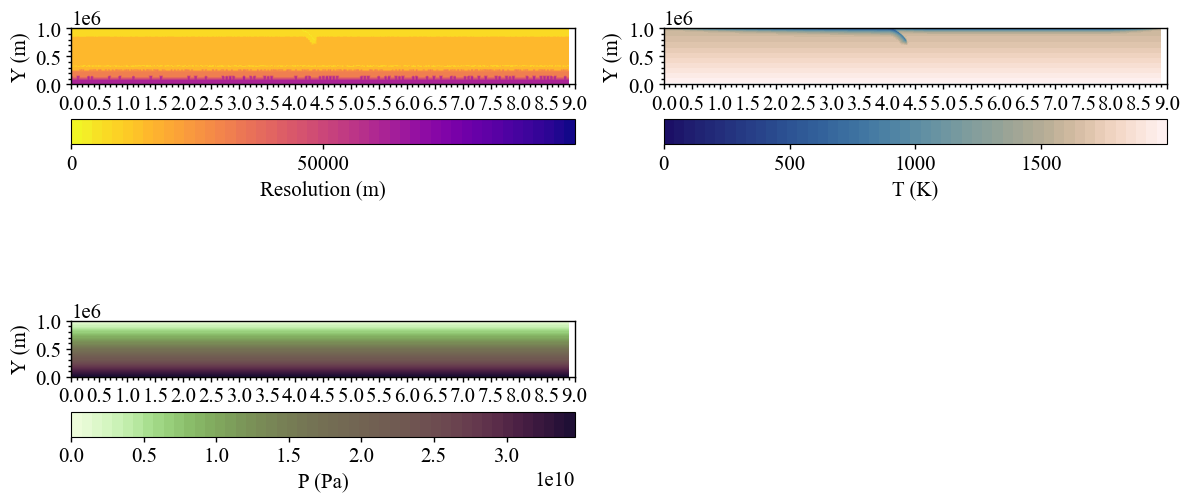

In [7]:
if create_2d_cases and run_create_2d_cases_first_step:

    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator
    from matplotlib import gridspec
    from cmcrameri import cm as ccm

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, np.ceil(box_length/1000e3)*1000e3)
    x_tick_interval = 500e3   # tick interval along x
    y_lim = (0.0, 1000e3)
    y_tick_interval = 500e3 # tick interval along y

    resolution_lim = (0.0, 100e3) # resolution
    resolution_level = 50  # number of levels in contourf plot
    resolution_tick_interval = 50e3  # tick interval along v

    T_lim = (0.0, 2000.0) # T
    T_level = 50  # number of levels in contourf plot
    T_tick_interval = 500.0  # tick interval along v

    P_lim = (np.min(P_grid), np.max(P_grid)) # P
    P_level = 50  # number of levels in contourf plot
    P_tick_interval = 5e9  # tick interval along v

    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # Create a figure with a 2x2 grid layout
    fig = plt.figure(figsize=(12, 6), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    # Plot the mesh resolution
    ax = fig.add_subplot(gs[0, 0])

    levels = np.linspace(resolution_lim[0], resolution_lim[1], resolution_level)
    ticks=np.arange(resolution_lim[0], resolution_lim[1], resolution_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, resolutions_grid,  vmin=resolution_lim[0], vmax=resolution_lim[1], levels=levels, cmap="plasma_r")  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="Resolution (m)", orientation='horizontal')  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot T
    ax = fig.add_subplot(gs[0, 1])

    levels = np.linspace(T_lim[0], T_lim[1], T_level)
    ticks=np.arange(T_lim[0], T_lim[1], T_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, T_grid,  vmin=T_lim[0], vmax=T_lim[1], levels=levels, cmap=ccm.lapaz)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="T (K)", orientation='horizontal')  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)


    # Plot P
    ax = fig.add_subplot(gs[1, 0])

    levels = np.linspace(P_lim[0], P_lim[1], P_level)
    ticks=np.arange(P_lim[0], P_lim[1], P_tick_interval)

    color_map = ax.contourf(x_grid, y_grid, P_grid,  vmin=P_lim[0], vmax=P_lim[1], levels=levels, cmap=ccm.tokyo_r)  # Resolution colormap
    cbar = fig.colorbar(color_map, ax=ax, label="P (Pa)", orientation='horizontal')  # Add colorbar
    cbar.set_ticks(ticks)

    ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    file_path = os.path.join(img_dir, "Initial_condition.png")
    fig.savefig(file_path)
    print("Saved figure %s" % file_path)

    # Reset rcParams to defaults
    rcdefaults()